In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score

In [2]:
### to unzip ameriflux data
files = [n for n in os.listdir() if n.endswith('.zip')]

for n in files:
    with zipfile.ZipFile(n, 'r') as zip_ref:
        zip_ref.extractall()

In [3]:
s2 = pd.read_csv('ameriflux_Sentinel1.csv')
sites = s2['name'].unique()

In [4]:
data, names = [], []

for n in files[:]:
    name = n[:-18]
    years = n[-17:-4]
    name = name+'_DD_'+years+'.csv'
    df = pd.read_csv(name)
    df = df.set_index(pd.to_datetime(df['TIMESTAMP'], format='%Y%m%d'))
    df[df == -9999] = np.nan
    

    station = name[4:10]
    s2_sub = s2[s2['name'] == station]
    s2_sub = s2_sub.set_index(pd.to_datetime(s2_sub['date']))
    s2_sub = s2_sub.sort_index()
    s2_sub = s2_sub[~s2_sub.index.duplicated()]
    df['NDVI'] = s2_sub['NDVI']
    df['VREI'] = s2_sub['VREI']
    df['NDRE'] = s2_sub['NDRE']
    
    new_df = df.dropna(subset=['NDVI', 'VREI'])
    if len(new_df) > 0:
        r2_1 = new_df['GPP_NT_VUT_MEAN'].corr(new_df['NDVI'])
        r2_2 = new_df['GPP_NT_VUT_MEAN'].corr(new_df['VREI'])
        if 'GPP_NT_VUT_MEAN' in df.columns:
            data.append(new_df)
            names.append(station)
        else:
            new_df['GPP_NT_VUT_MEAN'] = new_df['GPP_DT_VUT_MEAN']
            data.append(new_df)
            names.append(station)

In [5]:
data = pd.concat(data)
data = data.dropna(subset=['GPP_NT_VUT_MEAN', 'NDVI', 'VREI'])

In [6]:
y = data['GPP_NT_VUT_MEAN']
x = data['NDVI']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
z_norm = (z - z.min()) / (z.max() - z.min())
alpha = z_norm  # You can also do 1 - z_norm to flip transparency

x_vrei = data['VREI']
xy_vrei = np.vstack([x_vrei,y])
z_vrei = gaussian_kde(xy_vrei)(xy_vrei)
z_norm_vrei = (z_vrei - z_vrei.min()) / (z_vrei.max() - z_vrei.min())
alpha_vrei = z_norm_vrei  # You can also do 1 - z_norm to flip transparency

x_ndre = data['NDRE']
xy_ndre = np.vstack([x_ndre,y])
z_ndre = gaussian_kde(xy_ndre)(xy_ndre)
z_norm_ndre = (z_ndre - z_ndre.min()) / (z_ndre.max() - z_ndre.min())
alpha_ndre = z_norm_ndre  # You can also do 1 - z_norm to flip transparency

C:\Users\ignis\AppData\Local\Temp\ipykernel_47128\3798077503.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x, x_vrei, x_ndre],


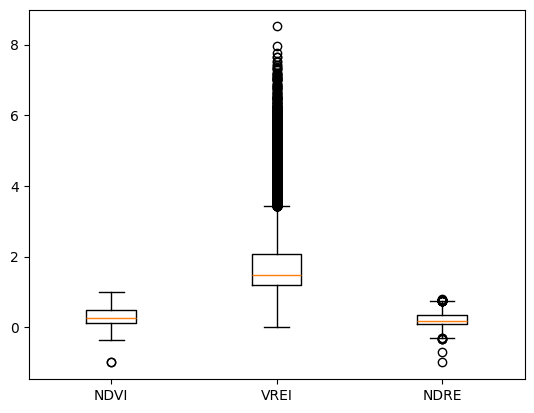

In [7]:
plt.boxplot([x, x_vrei, x_ndre],
            labels=['NDVI', 'VREI', 'NDRE'])
plt.show()

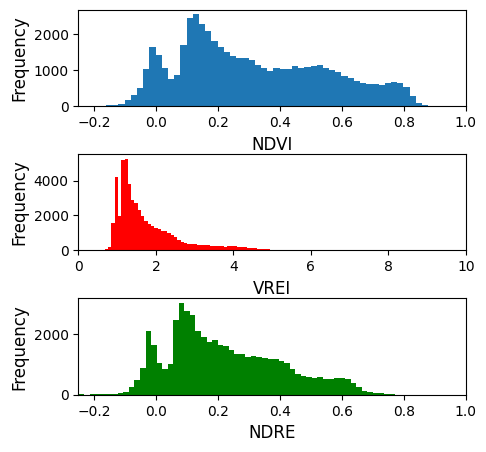

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(5, 5))
plt.subplots_adjust(hspace=0.5) # Adjust horizontal spacing
ax[0].hist(x, bins=100) #cmap='terrain_r')#
ax[0].set_ylabel(r'Frequency', fontsize=12)
ax[0].set_xlabel('NDVI', fontsize=12)
ax[0].set_xlim(-0.25, 1)

ax[1].hist(x_vrei, bins=100, color='red')
ax[1].set_xlim(0, 10)
ax[1].set_ylabel(r'Frequency', fontsize=12)
ax[1].set_xlabel('VREI', fontsize=12)

ax[2].hist(x_ndre, bins=100, color='green') #cmap='terrain_r')#
ax[2].set_xlim(-0.25, 1)
ax[2].set_ylabel(r'Frequency', fontsize=12)
ax[2].set_xlabel('NDRE', fontsize=12)
plt.show()

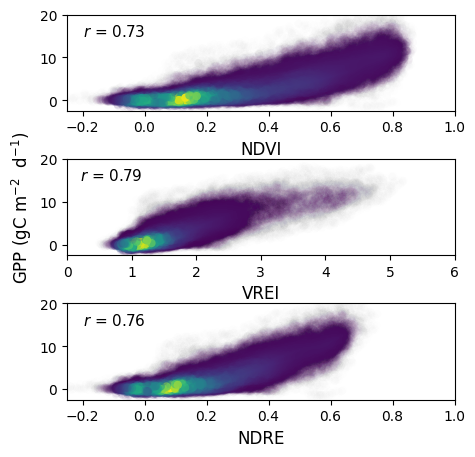

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(5, 5))
plt.subplots_adjust(hspace=0.5) # Adjust horizontal spacing
ax[0].scatter(x, y, c=z, alpha=alpha, edgecolors='none') 
ax[0].set_xlabel('NDVI', fontsize=12)
ax[0].set_ylim(-2.5, 20)
ax[0].set_xlim(-0.25, 1)
# ax[0].set_xlim(-2.5, 20)
ax[0].text(-0.2, 15, '$r$ = {}'.format(round(x.corr(y), 2)), fontsize=11)

ax[1].scatter(x_vrei, y, c=z_vrei, alpha=alpha_vrei, edgecolors='none')
ax[1].set_ylim(-2.5, 20)
ax[1].set_xlim(0, 6)
ax[1].set_ylabel(r'GPP (gC m$^{−2}$  d$^{−1}$)', fontsize=12)
ax[1].set_xlabel('VREI', fontsize=12)
ax[1].text(0.2, 15, '$r$ = {}'.format(round(x_vrei.corr(y), 2)), fontsize=11)

ax[2].scatter(x_ndre, y, c=z_ndre, alpha=alpha_ndre, edgecolors='none') 
ax[2].set_ylim(-2.5, 20)
ax[2].set_xlim(-0.25, 1)
ax[2].set_xlabel('NDRE', fontsize=12)
ax[2].text(-0.2, 15, '$r$ = {}'.format(round(x_ndre.corr(y), 2)), fontsize=11)
plt.show()